In [1]:
import os
import torch
import torchvision
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from utils.engine import evaluate

/home/hemyo/anaconda3/envs/env1/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Configure Path

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

num_classes = 1
CLASSES = ["BG","tuna"]

DATABASE_BASE = "/mnt/89404b8e-11a5-4c68-812b-e0ca2c3ea07d/3_TUNA_PROTOTYPE/cage+gate/training/"
test_image_path = DATABASE_BASE + "test/vlcsnap-2023-10-31-16h24m29s687.png"

model_save_path = "trained_model/cage+gate/v1/"
model_save_name = model_save_path + "fasterrcnn_resnet50_fpn_best"

In [3]:
# set the device we will be using to run the model
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Define model

In [4]:
import torchvision.models.detection as torch_det

# detection_model = torch_det.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
detection_model = torch_det.fasterrcnn_resnet50_fpn(pretrained=True)

/home/hemyo/anaconda3/envs/env1/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/hemyo/anaconda3/envs/env1/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
in_features = detection_model.roi_heads.box_predictor.cls_score.in_features
detection_model.roi_heads.box_predictor = torch_det.faster_rcnn.FastRCNNPredictor(in_features, num_classes+1)

## Load Model

In [6]:
detection_model.load_state_dict(torch.load(model_save_name+".pt"))
detection_model.to(DEVICE)
detection_model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

## Load image

In [7]:
# load the image from disk
image = cv2.imread(test_image_path)
orig = image.copy()

# convert the image from BGR to RGB channel ordering and change the
# image from channels last to channels first ordering
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = image.transpose((2, 0, 1))

# add the batch dimension, scale the raw pixel intensities to the
# range [0, 1], and convert the image to a floating point tensor
image = np.expand_dims(image, axis=0)
image = image / 255.0
image = torch.FloatTensor(image)

In [8]:
# send the input to the device and pass the it through the network to
# get the detections and predictions
image = image.to(DEVICE)
detections = detection_model(image)[0]

## Display result

In [13]:
# Set iou_threshold (minimum confidence)
iou_threshold = 0.5

COLORS = [(255, 0, 0), (255, 255, 0), (0, 255, 255)]
# loop over the detections
for i in range(0, len(detections["boxes"])):
    # extract the confidence (i.e., probability) associated with the prediction
    confidence = detections["scores"][i]
    # filter out weak detections by ensuring the confidence is greater than the minimum confidence
    if confidence > iou_threshold :
        # extract the index of the class label from the detections,
        # then compute the (x, y)-coordinates of the bounding box for the object
        idx = int(detections["labels"][i])
        box = detections["boxes"][i].detach().cpu().numpy()
        (startX, startY, endX, endY) = box.astype("int")
        centerX = int((startX+endX)/2)
        centerY = int((startY+endY)/2)
        center_pos = (centerX, centerY)
        
        # display the prediction to our terminal
        label = "{}: {:.2f}%".format(CLASSES[idx], confidence * 100)
        # print("[INFO] {}".format(label))
        
        # draw the bounding box and label on the image
        # cv2.rectangle(orig, (startX, startY), (endX, endY),COLORS[idx], 2)
        cv2.circle(orig, center_pos, radius=1, color=COLORS[idx], thickness=2)
        y = startY - 15 if startY - 15 > 15 else startY + 15
        cv2.putText(orig, label, (startX, y),cv2.FONT_HERSHEY_SIMPLEX, 0.5, COLORS[idx], 2)

[INFO] tuna: 99.97%
[INFO] tuna: 99.93%
[INFO] tuna: 99.90%
[INFO] tuna: 99.89%
[INFO] tuna: 99.89%
[INFO] tuna: 99.74%
[INFO] tuna: 99.74%
[INFO] tuna: 99.72%
[INFO] tuna: 99.67%
[INFO] tuna: 99.66%
[INFO] tuna: 99.60%
[INFO] tuna: 99.57%
[INFO] tuna: 99.42%
[INFO] tuna: 99.37%
[INFO] tuna: 99.26%
[INFO] tuna: 99.13%
[INFO] tuna: 99.03%
[INFO] tuna: 98.98%
[INFO] tuna: 98.97%
[INFO] tuna: 98.95%
[INFO] tuna: 98.69%
[INFO] tuna: 98.55%
[INFO] tuna: 98.39%
[INFO] tuna: 98.33%
[INFO] tuna: 98.21%
[INFO] tuna: 97.80%
[INFO] tuna: 97.51%
[INFO] tuna: 97.21%
[INFO] tuna: 95.77%
[INFO] tuna: 95.05%
[INFO] tuna: 93.03%
[INFO] tuna: 92.64%
[INFO] tuna: 91.95%
[INFO] tuna: 91.78%
[INFO] tuna: 89.74%
[INFO] tuna: 83.28%
[INFO] tuna: 82.48%
[INFO] tuna: 74.11%
[INFO] tuna: 72.17%
[INFO] tuna: 68.68%
[INFO] tuna: 66.71%
[INFO] tuna: 62.60%
[INFO] tuna: 60.64%
[INFO] tuna: 56.75%
[INFO] tuna: 52.04%
[INFO] tuna: 50.58%


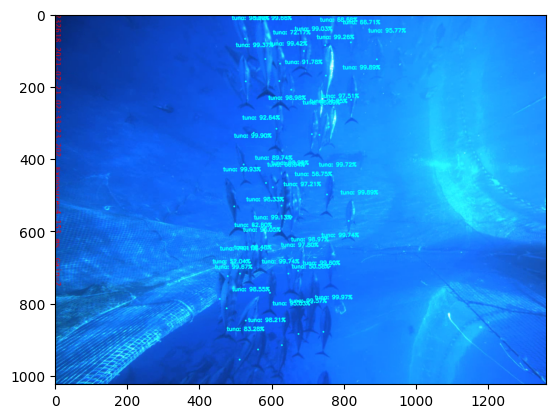

In [14]:
# show the output image
plt.imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))